In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Carrega dados e metadados
splits = ["train[:80%]", "train[80%:90%]", "train[90%:100%]"] #define divisao dos dados para treinamento, teste e validação
train_ds, val_ds, test_ds = tfds.load("cats_vs_dogs",
                                       split=splits,
                                       as_supervised=True, #imagem, rótulo
                                       with_info=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.QJ9U7M_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [2]:
IMG_SIZE = (150, 150) #dimensao da imagem
BATCH_SIZE = 32 #lotes de imagens

#préprocessamento da imagem
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

#faz ajustes aleatórios nas imagens pro modelo aprender de fato
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

# preparação do conjunto de treino e validação
train_ds = (train_ds.map(preprocess)
                    .map(augment)
                    .shuffle(1000)
                    .batch(BATCH_SIZE)
                    .prefetch(tf.data.AUTOTUNE))

val_ds = (val_ds.map(preprocess)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.AUTOTUNE))
# Não usamos augmentação aqui, pois na validação queremos ver como o modelo se sai com imagens "reais", sem distorções.


In [3]:
from tensorflow.keras import layers, models

base_model = tf.keras.applications.MobileNetV2(input_shape=(*IMG_SIZE, 3), #define o tamanho de entrada da imagem e canais de cor(3)
                                               include_top=False, # remove a parte final (a "cabeça") do modelo original, que fazia classificação de 1000 classes do ImageNet.
                                               weights="imagenet")
#MobileNetV2: é um modelo pré-treinado em milhões de imagens do ImageNet.

base_model.trainable = False #congela modelo base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), #Reduz as saídas do base_model para um vetor pequeno.
    layers.Dense(1, activation="sigmoid")
])


/tmp/ipython-input-3-3211638341.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(*IMG_SIZE, 3), #define o tamanho de entrada da imagem e canais de cor(3)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
#treinamento e compilação do modelo


model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 415s 700ms/step - accuracy: 0.9214 - loss: 0.1744 - val_accuracy: 0.9626 - val_loss: 0.0999
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 405s 693ms/step - accuracy: 0.9622 - loss: 0.0926 - val_accuracy: 0.9639 - val_loss: 0.0981
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 445s 699ms/step - accuracy: 0.9670 - loss: 0.0836 - val_accuracy: 0.9665 - val_loss: 0.0917
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 486s 775ms/step - accuracy: 0.9696 - loss: 0.0755 - val_accuracy: 0.9673 - val_loss: 0.0906
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 452s 773ms/step - accuracy: 0.9693 - loss: 0.0772 - val_accuracy: 0.9652 - val_loss: 0.0950


In [5]:
base_model.trainable = True
fine_tune_at = 100  # ex.: últimas camadas

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_ft = model.fit(train_ds,
                       epochs=10,
                       validation_data=val_ds,
                       initial_epoch=history.epoch[-1]) #garante que O treinamento continue de onde parou

Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 746s 1s/step - accuracy: 0.8980 - loss: 0.2406 - val_accuracy: 0.9626 - val_loss: 0.1010
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 710s 1s/step - accuracy: 0.9527 - loss: 0.1147 - val_accuracy: 0.9656 - val_loss: 0.0915
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 726s 1s/step - accuracy: 0.9664 - loss: 0.0877 - val_accuracy: 0.9673 - val_loss: 0.0879
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 680s 1s/step - accuracy: 0.9725 - loss: 0.0723 - val_accuracy: 0.9686 - val_loss: 0.0842
Epoch 9/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 689s 1s/step - accuracy: 0.9781 - loss: 0.0608 - val_accuracy: 0.9699 - val_loss: 0.0795
Epoch 10/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 771s 1s/step - accuracy: 0.9810 - loss: 0.0500 - val_accuracy: 0.9686 - val_loss: 0.0827


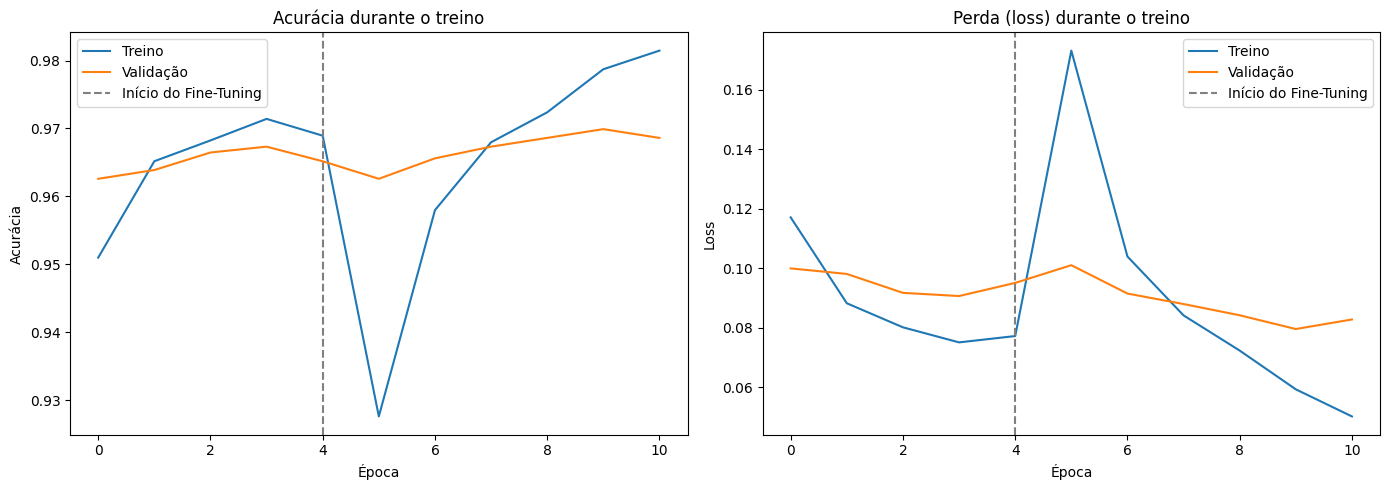

In [6]:
import matplotlib.pyplot as plt

# Junta os históricos anteriores
acc = history.history["accuracy"] + history_ft.history["accuracy"]
val_acc = history.history["val_accuracy"] + history_ft.history["val_accuracy"]

loss = history.history["loss"] + history_ft.history["loss"]
val_loss = history.history["val_loss"] + history_ft.history["val_loss"]

epochs_range = range(len(acc))

# Plotando
plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Treino")
plt.plot(epochs_range, val_acc, label="Validação")
plt.axvline(x=history.epoch[-1], color="gray", linestyle="--", label="Início do Fine-Tuning")
plt.title("Acurácia durante o treino")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Treino")
plt.plot(epochs_range, val_loss, label="Validação")
plt.axvline(x=history.epoch[-1], color="gray", linestyle="--", label="Início do Fine-Tuning")
plt.title("Perda (loss) durante o treino")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# teste final

from tensorflow.keras.preprocessing import image
import numpy as np

# Carrega a imagem com o mesmo tamanho que usamos no treino
img = image.load_img("dog.jpg", target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

# Interpreta o resultado
class_names = ["Cat", "Dog"]
predicted_class = class_names[int(prediction[0] > 0.5)]

print(f"Predição: {predicted_class} (score = {prediction[0][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predição: Dog (score = 0.9989)


/tmp/ipython-input-7-3153188089.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_names[int(prediction[0] > 0.5)]
